# Correlation based feature selection method for classification
This notebook contains an implementation of a feature selection method, based only on the dataset variables correlation properties. 
Feature selection and dimensionality reduction are common tasks in data analysis and are usually performed before developing Machine Learning models. In many applications, given a dataset with a lot of variables, a data scientist needs to understand which input features are more significant to predict the desired outcome (the outcome could be a continuous variable in the case of regression, or a discrete variable in the case of classification) and which one are irrelevant, or at least less significant and can be neglected in the modelling phase. Moreover, dimensionality reduction methods allows to simplify the problem structure, thus improving the generalization capability of the mathematical model (we simply expect to reduce the underlaying model complexity). Another advantage of reducing the problem dimension is the decrease of the computational cost during training and validation phases.

## Madelon dataset
In this notebook, we will apply the proposed method to the Madelon dataset, obtaining a subset of the most "important" features.
Madelon is a benchmark artificial dataset used to simulate a high-dimension classification problem. We are dealing with a binary classification problem with 500 continuous input features and 1 array of class labels. Class labels are {-1, +1}. 
Original feature names are integers, ranging from 0 up to 499.

## Methodology
The goal of this study is to reduce the dimensionality of the Madelon problem to an "acceptable" number of input features, dropping the less significant variables. So we want to apply a filtering technique.

In "sklearn" package there are many feature selection methods that can be used to perform this task. However, common filtering techniques are based on the results of some mathematical models like Lasso regressor or decision trees, that have been previously fit to the dataset. 
Another limitation of some methods are that we have embedded hyper-parameters that have to be tuned, or that we should know a priori the number of significant features from the entire collection of features.

The proposed method instead, is based only on the feature-to-feature correlation and the feature-to-target correlation properties. In few words, only information from the data are used and there is no need of training and validating a mathematical model for feature selection. More in detail, this method does not make any assumption on the number of features to be selected. 

## Libraries
Following packages are needed to run the notebook.

In [6]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from math import sqrt

## Import the dataset 
Madelon dataset can be directly imported by UCI repository, with Pandas read_csv. Otherwise, one could save the dataset manually in the notebook folder and import the data files in a similar way. 
Input features are contained in the 'madelon_train.data' file, while the outcome (so the array of labels) is in the 'madelon_train.data' file.

Please note that getting data from the URLs may take a while.

In [5]:
uci_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
uci_target_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'

uci_target = pd.read_csv(uci_target_url, header = None) # assigning the target data to 'uci_target'

uci_train = pd.read_csv(uci_train_url, delimiter=' ', header=None)
print("Training set has originally {} rows and {} columns".format(uci_train.shape[0], uci_train.shape[1]))

Training set has originally 2000 rows and 501 columns


## Pre-processing
We can drop the column number 500, since it contains only NaN entries.

In [7]:
uci_train.drop(columns = 500, inplace = True)

It is a good practice to rename the dataframes column usin a string type, rather than integer type. Following loop renames the variables from "V000" until "V499", preserving the number of 500 input features.

In [8]:
column_names = list()
for column_int in uci_train.columns.to_list():
    if column_int < 10:
        column_names.append("V00{}".format(column_int + 1))
    elif ((column_int >= 10) & (column_int < 100)):
        column_names.append("V0{}".format(column_int + 1))
    elif column_int >= 100:
        column_names.append("V{}".format(column_int + 1))

#print(column_names)

X_train = pd.DataFrame(data = uci_train.values, columns = column_names)
X_train

,V001,V002,V003,V004,V005,V006,V007,V008,V009,V0010,...,V491,V492,V493,V494,V495,V496,V497,V498,V499,V500
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,490,505,503,474,463,461,519,476,518,467,...,467,479,449,588,499,506,475,463,507,501
1996,480,475,476,480,495,482,515,479,480,484,...,464,474,473,424,454,570,476,493,465,485
1997,480,517,631,470,485,474,535,476,493,466,...,501,483,479,687,488,488,483,500,523,481
1998,484,481,505,478,542,477,518,477,510,472,...,487,483,526,750,486,529,484,473,527,485


In [9]:
np.unique(uci_target)

array([-1,  1], dtype=int64)

We can change the label column from numeric to categorical type.

In [10]:
y_train = pd.DataFrame(data = uci_target.values, columns = ["class"])

# change the class label -1 to 0
y_train.replace({-1 : 0}, inplace = True)
y_train["class"] = y_train["class"].astype("category")
y_train

,class
0,0
1,0
2,0
3,1
4,1
...,...
1995,1
1996,0
1997,0
1998,1


It's more handy to concatenate the features dataframe and the target labels dataframe together. In this way, the whole "cleaned" dataset can be passed to the following function using only 2 arguments (the whole dataset and the name of the target column, because we assume that all other columns of the whole dataset contain the features to be searched).

In [14]:
training_df = pd.concat([X_train, y_train], axis = 1)

## Searching the most informative subset of features
I have split the search in more functions, to make each step clearer. Let's see the "ingredients" of the research algorithm.

### Compute the correlation metrics
We need a metric to compute the feature-to-feature and feature-to-target correlation. For what regards the feature-to-target correlation, if the target variable were continuous, we could apply the Pearson correlation coefficient, that measures the linear relationship between two random variables. The Pearson correlation coefficient is the ratio between the covariance of two variables and the product of their standard deviations. Like other correlation coefficients, the Pearson coefficient varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. We're not dealing with a regression problem, but with a classification problem (i.e. the target is discrete, and here also categorical). The relationship between a binary variable and a continuous variable, can be evaluated using the point biserial correlation. 
The formula can be retrived from "stats" module official documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html

Instead, for what regards the computation of the average feature-to-feature correlation, we can use the Pearson correlation, since all features are continuous.

In [16]:
def pointbiserial_corr(x, y):
    """
    Calls the pointbiserial correlation from 'stats' module, given 2 numpy arrays.
    The output is the absolute value of the correlation coefficient.
    """
    # calculates the absolute value of the pointbiserial correlation 
    # (note the '0' item, to get only the corr value and not the p_value)
    return abs(pointbiserialr(x, y)[0])

Note that the function above calls the pointbiserial correlation for 2 given arrays and takes the absolute value.

### Merit score
The merit is a metric associated to a subset of features, drawn from the original features space. In the numerator, we have the average feature-to-target correaltion, in the denominator the square root of the the average feature-to-feature correlation. The constant terms are based on k, which is the number of features in the considered subset.

Given a subset of features, the merit is higher when the average feature-to-feature correlation is lower (selected features are generally uncorrelated to each other) and when the average feature-to-target correlation is higher (selected features are likely to impact on the tagret).

In [17]:
def getMerit(df, subset, class_label):
    """
    Computes the merit score for a subset of the input features taken from the given dataframe, with the target class column.
    
    arguments:
        df : pandas dataframe containing (X, y) columns all together
        subset : lis of strings
            list of input fetaures to be used for calculating the merit
        class_label: str
            column name of df, containing the class label ID
    """
    X = df[subset] # get only the columns contained in the 'subset' argument
    y = df[class_label]    
    k = len(subset)

    # average feature-class correlation
    # applies the above defined function to all columns of the X dataframe, passing the y dataframe as common 'target'
    corr_array = (X.apply(lambda x: pointbiserial_corr(x, y.values))).values # this is a numpy array
    rcf = np.mean(corr_array)

    # average feature-feature correlation
    corr_df = X[subset].corr() # pairwise correlation. The first output is a dataframe
    corr_df.values[np.tril_indices_from(corr_df.values)] = np.nan # get only the upper triangular
    corr_df = abs(corr_df) # apply the absolute value
    rff = corr_df.unstack().mean() # note that pandas 'mean' will skip the NaN entries. This is a scalar.

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [18]:
# example how to call the merit function
sample_merit = getMerit(training_df, subset = ["V500", "V001", "V003"], class_label = "class" )
sample_merit

0.008899487891043917

### Best first search
The algorithm has to start from a first guess of features. A good starting point is to select the feature having the highest merit. So the first subset contains only 1 feature, and this one is the "most significant".

From the definition of the merit score, when k = 1, the merit degenerates to the value of the feature-to-class correlation, for each feature in the original feature space. We can simply apply the pointbiserial function to all columns of the whole dataset and rank the features according to their correlation score with the target.

In [19]:
def get_best_first_search(df, class_label): 
    """
    Gets the feature with higher merit.
    
    Arguments:
        df : pandas dataframe
            The whole dataframe, containing both input features and class label column.
        class_label : str
            Column name of the class label column.
    Return:
        (best_feature, best_value) : tuple
            Returns the feature with higher merit and its merit value.
    """
    X = df.drop(columns = class_label)
    y = df[class_label]
    corr_series = X.apply(lambda x: pointbiserial_corr(x, y.values))
    corr_series.sort_values(ascending = False, inplace = True)
    return corr_series.index[0], corr_series[0]

best_feature, best_value = get_best_first_search(training_df, "class")
print("Best feature is: {} with merit: {}".format(best_feature, best_value))

Best feature is: V476 with merit: 0.2199331363610972


### Putting all together in the search function
The following function contains the core of the algorithm. How does the search algorithm work ? 

#### Initialization
The first guess is expressed as the feature with higher merit. We initialize a queue dataframe to contain the succession of subsets that will be searched, putting the feature with higher merit in the first (index 0) position. 
Already visited subsets and their score is recorded in 2 lists: this enables to track the algorithm search history. The number of backtracks is initialized to 0, since it's a counter that will be incremented in the while loop. Note that we imposed a max number of backtracks to 5. This is an arbitrary choice: we could also select another number.

#### Subset expansion
The algorithm iteratively expands the subset on the top of the queue (i.e. the subset which has an associated higher "priority") with all other possible features and looks for the feature that increases the merit the most. In this way, at the end of the inner "for" loop, we obtain another subset which consists in the same subset at the previous iteration, plus the new best-performing feature drawn from the whole dataframe. If the new subset performs worse than the old one, than the search jumps back to the old one, performing litterally a "backtrack". Otherwise, the search continues by expanding the improved subset of the features.

#### Stopping criteria
The search process terminates when either the queue dataframe is empty or maximum allowed number of backtracks has been reached. Limiting the number of backtracks is something like imposing a limit to the improvement that can be reached by adding even more features to the subset.

In [20]:
def search_best_features_set(df, class_label, max_backtrack = 5):
    
    best_subset, best_value = get_best_first_search(df, class_label)
    
    # initialize the queue dataframe with the overall best merit feature
    queue = pd.DataFrame({"features" : [[best_feature]], "priority" : best_value})
    iteration = 0
    visited = []
    visited_score = []
    n_backtrack = 0
    
    while ((not queue.empty) and (n_backtrack <= max_backtrack)):
        # sort the queue dataframe according to the descending merit and get the highes set
        queue.sort_values(by = "priority", ascending = False, inplace = True, ignore_index = True)
        subset = queue.loc[0, "features"]
        priority = queue.loc[0, "priority"]
        queue.drop(index = 0, inplace = True)
        
        # check if the new found set has better performance than the previous
        if priority < best_value:
            n_backtrack = n_backtrack + 1 # the new subset is not improving the score
        else:
            best_value = priority # this means the new subset is improving the score
            best_subset = subset
            
        # consider feature in the input dataframe, except the one containing the class label and the columns
        # contained in the best subset
        column_names = df.drop(columns = [class_label] + subset).columns.to_list() 
        
        for column_name in column_names:
            temp_subset = subset + [column_name]
            # check if the actual set of variables has already been tested
            already_visited = (any([set(temp_subset) == set(element) for element in visited]))
            if already_visited:
                print("{} already visited.".format(set(temp_subset)))
            else:
                visited.append(temp_subset)
                merit = getMerit(df, temp_subset, class_label = class_label)
                visited_score.append(merit)
                new_item = pd.DataFrame({"features" : [temp_subset], "priority" : merit})
                queue = queue.append(new_item, ignore_index = True)
                del new_item
        iteration = iteration + 1 
        print("Search iter # {}".format(iteration))
    return (best_subset, best_value, visited, visited_score)

## Running the algorithm
Running the search function may take some time.

In [21]:
(best_subset, best_value, visited, visited_score) = search_best_features_set(training_df, "class") 

Search iter # 1
Search iter # 2
Search iter # 3
Search iter # 4
Search iter # 5
Search iter # 6
Search iter # 7
Search iter # 8
Search iter # 9
Search iter # 10
Search iter # 11
Search iter # 12
Search iter # 13
Search iter # 14
Search iter # 15
Search iter # 16
Search iter # 17
Search iter # 18
Search iter # 19
Search iter # 20
Search iter # 21
Search iter # 22
Search iter # 23
Search iter # 24
Search iter # 25
Search iter # 26
Search iter # 27
Search iter # 28
Search iter # 29
Search iter # 30
Search iter # 31
Search iter # 32
Search iter # 33
Search iter # 34
Search iter # 35
Search iter # 36
Search iter # 37
Search iter # 38
Search iter # 39
Search iter # 40
Search iter # 41
Search iter # 42
Search iter # 43
Search iter # 44
Search iter # 45
Search iter # 46
Search iter # 47
Search iter # 48
Search iter # 49
Search iter # 50
Search iter # 51
Search iter # 52
Search iter # 53
Search iter # 54
Search iter # 55
Search iter # 56
Search iter # 57
Search iter # 58
Search iter # 59
Search

In [23]:
len(best_subset)

60

In [24]:
best_value

0.3034575055824045

In [25]:
print("Problem dimensionality has been reduced from {} to {} features.".format(training_df.shape[1], len(best_subset))) 

Problem dimensionality has been reduced from 501 to 60 features.


In [26]:
reduced_df = pd.concat([X_train[best_subset], y_train], axis = 1)
reduced_df

,V476,V049,V242,V324,V206,V283,V297,V425,V431,V056,...,V446,V106,V228,V044,V286,V473,V153,V445,V086,class
0,401,440,434,476,476,492,477,496,505,469,...,479,181,478,508,516,515,483,467,497,0
1,549,499,551,463,477,491,484,457,486,485,...,478,431,477,493,480,465,475,472,447,0
2,454,460,474,486,478,485,471,474,497,525,...,478,593,477,486,522,485,493,490,516,0
3,602,529,569,458,477,470,465,501,486,478,...,480,698,479,464,433,457,482,489,419,1
4,560,429,538,485,478,497,446,504,450,493,...,478,451,479,481,502,500,466,517,477,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,538,505,535,466,477,526,505,502,507,495,...,480,541,476,466,499,483,494,512,491,1
1996,601,448,590,478,475,483,506,475,489,507,...,478,696,475,482,505,444,489,500,476,0
1997,437,544,463,471,478,474,471,480,444,485,...,476,752,477,507,479,449,483,532,503,0
1998,387,490,443,479,475,478,514,469,456,467,...,478,524,479,486,476,511,475,501,475,1


Save the reduced dataframe to the local working folder.

In [33]:
base_dir = os.getcwd()
reduced_df_file_name = "Madelon_dataset_reduced.csv"
reduced_df_full_path = os.path.join(base_dir, reduced_df_file_name)

reduced_df.to_csv(reduced_df_full_path, index = False)

## Fitting a binary classifier
After that the number of input features has been reduced to a reasonable number, we can try to fit a simple mathematical model suited for binary classification: a logistic regressor. 
I am going to use the implementation available in the "sklearn" library, but with the embedded cross validation method, for the estimation of the most importnat hyperparameter for logit-regressor models, i.e. the C parameter. The class "LogisticRegressionCV" has been developed exactly for this kind of task. Instead of first initializing the basic model and than applying the parameter search strategy to find the best parameter set, we can do it in just few lines of code, using the aforementioned class. 
I also prefer to add a scaler, to rescale all features into a common interval, before fitting the hypermodels. Rescaling task can be addes as a pre-processing part of a pipeline.

In [111]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [113]:
X = pd.read_csv(os.path.join(os.getcwd(), "Madelon_dataset_reduced.csv"))
X_logit_train, X_logit_test, y_logit_train, y_logit_test = train_test_split(X, X["class"], 
                                                    test_size=0.33)
X

,V476,V049,V242,V324,V206,V283,V297,V425,V431,V056,...,V446,V106,V228,V044,V286,V473,V153,V445,V086,class
0,401,440,434,476,476,492,477,496,505,469,...,479,181,478,508,516,515,483,467,497,0
1,549,499,551,463,477,491,484,457,486,485,...,478,431,477,493,480,465,475,472,447,0
2,454,460,474,486,478,485,471,474,497,525,...,478,593,477,486,522,485,493,490,516,0
3,602,529,569,458,477,470,465,501,486,478,...,480,698,479,464,433,457,482,489,419,1
4,560,429,538,485,478,497,446,504,450,493,...,478,451,479,481,502,500,466,517,477,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,538,505,535,466,477,526,505,502,507,495,...,480,541,476,466,499,483,494,512,491,1
1996,601,448,590,478,475,483,506,475,489,507,...,478,696,475,482,505,444,489,500,476,0
1997,437,544,463,471,478,474,471,480,444,485,...,476,752,477,507,479,449,483,532,503,0
1998,387,490,443,479,475,478,514,469,456,467,...,478,524,479,486,476,511,475,501,475,1


In [114]:
scaler = StandardScaler() # initialize the scaler

# initialize the logistic regressor. We will use the standard 5-folds implementation for the cross validation.
# class weight "balanced" takes into account the fact that there may be some class imbalance.
logit_model = LogisticRegressionCV(Cs = np.logspace(start = -9, stop = 9, num = 19), 
                                   scoring = "f1", class_weight = "balanced", max_iter = 1000)

classifier = Pipeline([('scaler', scaler), ('logit_model', logit_model)])

In [115]:
classifier.fit(X_logit_train, y_logit_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logit_model',
                 LogisticRegressionCV(Cs=array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08, 1.e+09]),
                                      class_weight='balanced', max_iter=1000,
                                      scoring='f1'))])

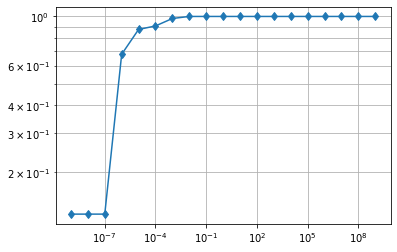

In [116]:
plt.loglog(classifier["logit_model"].Cs_, np.mean(classifier["logit_model"].scores_[1], axis = 0), marker = "d")
plt.grid(which = "both")

In [117]:
score = classifier.score(X_logit_test, y_logit_test)
score

1.0

## References
This work is based on the Python implementation by Johannes Fisher of the same method, that can be found here: https://johfischer.com/2021/08/06/correlation-based-feature-selection-in-python-from-scratch. 

Dataset repository: https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON

Hall, M. A. (2000). Correlation-based feature selection of discrete and numeric class machine learning.
Isabelle Guyon, Steve R. Gunn, Asa Ben-Hur, Gideon Dror, 2004. Result analysis of the NIPS 2003 feature selection challenge.